In [1]:
import pyabc
from pyabc import ABCSMC
from slad import *
import sklearn.gaussian_process as skl_gp

skl_gp.kernels.RBF() + skl_gp.kernels.WhiteKernel()

problem = CoreProblem()

distances = [
    pyabc.PNormDistance(),
    pyabc.AdaptivePNormDistance(adaptive=False, scale_function=pyabc.distance.median_absolute_deviation),
    pyabc.AdaptivePNormDistance(adaptive=True, scale_function=pyabc.distance.median_absolute_deviation),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=False, normalize_labels=False)),
    #pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=False)),
    pyabc.PNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=True)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=False), adaptive=True),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.LinearPredictorSumstat(normalize_features=True, normalize_labels=False, n_fit=4), adaptive=True),
    pyabc.PNormDistance(sumstat=pyabc.GPPredictorSumstat()),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat()),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(n_fit=4)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=skl_gp.kernels.RBF(length_scale=np.ones(4)) + skl_gp.kernels.WhiteKernel(), n_fit=4)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=skl_gp.kernels.RBF(length_scale=np.ones(4)) + skl_gp.kernels.WhiteKernel(), n_fit=4, joint=False)),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.GPPredictorSumstat(kernel=skl_gp.kernels.Matern(length_scale=np.ones(4)) + skl_gp.kernels.WhiteKernel(), n_fit=4)),
    pyabc.PNormDistance(sumstat=pyabc.PredictorSumstat(predictor=pyabc.MLPPredictor())),
    pyabc.AdaptivePNormDistance(sumstat=pyabc.PredictorSumstat(predictor=pyabc.MLPPredictor(), n_fit=4)),
    #pyabc.PNormDistance(sumstat=pyabc.PredictorSumstat(
    #    predictor=pyabc.ModelSelection(
    #        predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(), pyabc.MLPPredictor()]
    #    ),
    #    n_fit=1,
    #)),pyabc.PNormDistance(sumstat=pyabc.PredictorSumstat(
    #    predictor=pyabc.ModelSelection(
    #        predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(), pyabc.MLPPredictor()]
    #    ),
    #    n_fit=4,
    #)),
    pyabc.distance.InfoWeightedPNormDistance(predictor=pyabc.ModelSelection(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(), pyabc.MLPPredictor(),
                        pyabc.GPPredictor(kernel=skl_gp.kernels.RBF(length_scale=np.ones(4)) + skl_gp.kernels.WhiteKernel())]
        ),
        n_fit=1,
    ),
    pyabc.distance.InfoWeightedPNormDistance(predictor=pyabc.ModelSelection(
            predictors=[pyabc.LinearPredictor(), pyabc.GPPredictor(), pyabc.MLPPredictor(),
                        pyabc.GPPredictor(kernel=skl_gp.kernels.RBF(length_scale=np.ones(4)) + skl_gp.kernels.WhiteKernel()),
                        pyabc.GPPredictor(kernel=skl_gp.kernels.Matern(length_scale=np.ones(4)) + skl_gp.kernels.WhiteKernel())]
        ),
        n_fit=7,
    ),
]

labels = [
    'Euclidean',
    'Calibrated Euclidean',
    'Adaptive Euclidean',
    'Learned linear nn',
    #'Learned linear tn',
    'Learned linear tt',
    'Adaptive + LL tn',
    'Adaptive + LL tn n_fit=4',
    'GP',
    'Adaptive GP',
    'Adaptive GP n_fit=4',
    'Adaptive GP ARD n_fit=4',
    'Adaptive GP ARD separate n_fit=4',
    'Adaptive GP Matern ARD n_fit=4',
    'MLP',
    'Adaptive MLP n_fit=4',
    #'Model selection',
    #'Model selection n_fit=4',
    'Info weighted ms',
    'Info weighted ms n_fit=4',
]

def plot_history(history: pyabc.History, label: str):
    gt_pars = problem.get_gt_par()
    prior_bounds = problem.get_prior_bounds()
    
    fig, ax = plt.subplots(1,len(gt_pars))
    for t in range(history.max_t + 1):
        df, w = history.get_distribution(m=0, t=t)
        for ix, (par, (lb, ub)) in enumerate(prior_bounds.items()):
            if par == 'p1':
                lb, ub = 350, 450
            elif par == 'p0':
                lb, ub = 0, 0.1
            pyabc.visualization.plot_kde_1d(
                df, w, xmin=lb, xmax=ub, numx=300, refval=gt_pars,
                x=par, xname=par, ax=ax[ix],
                label="PDF t={}".format(t))
    ax[-1].axvline(0, color='k', linestyle='dashed', label="True value")
    #ax[-1].legend()
    ax[-1].set_title(label)

In [2]:
hs = []

for distance, label in zip(distances, labels):
    print(label)
    abc = ABCSMC(problem.get_model(), problem.get_prior(), distance, population_size=200)
    abc.new(pyabc.create_sqlite_db_id(), problem.get_obs())
    h = abc.run(max_total_nr_simulations=10e3)
    hs.append(h)

INFO:Sampler:Parallelizing the sampling on 4 cores.


Euclidean


INFO:History:Start <ABCSMC id=324, start_time=2021-04-12 00:07:00.533625>
INFO:ABC:Calibration sample t=-1.
INFO:Epsilon:initial epsilon is 288.4212598982951
INFO:ABC:t: 0, eps: 288.4212598982951.
INFO:ABC:Acceptance rate: 200 / 367 = 5.4496e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 182.20419516116613.
INFO:ABC:Acceptance rate: 200 / 372 = 5.3763e-01, ESS=1.9428e+02.
INFO:ABC:t: 2, eps: 112.93808174114506.
INFO:ABC:Acceptance rate: 200 / 489 = 4.0900e-01, ESS=1.8858e+02.
INFO:ABC:t: 3, eps: 71.87611021333723.
INFO:ABC:Acceptance rate: 200 / 613 = 3.2626e-01, ESS=1.8350e+02.
INFO:ABC:t: 4, eps: 51.539345575670325.
INFO:ABC:Acceptance rate: 200 / 867 = 2.3068e-01, ESS=1.9171e+02.
INFO:ABC:t: 5, eps: 34.812778691275525.
INFO:ABC:Acceptance rate: 200 / 1187 = 1.6849e-01, ESS=1.8315e+02.
INFO:ABC:t: 6, eps: 25.63739460142591.
INFO:ABC:Acceptance rate: 200 / 1719 = 1.1635e-01, ESS=1.8584e+02.
INFO:ABC:t: 7, eps: 17.88433691795862.
INFO:ABC:Acceptance rate: 200 / 1981 = 1.0096e-01, ESS=1.8806e

Calibrated Euclidean


INFO:Epsilon:initial epsilon is 2.6008436748689325
INFO:ABC:t: 0, eps: 2.6008436748689325.
INFO:ABC:Acceptance rate: 200 / 378 = 5.2910e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 2.0217794233537596.
INFO:ABC:Acceptance rate: 200 / 572 = 3.4965e-01, ESS=1.8493e+02.
INFO:ABC:t: 2, eps: 1.6553436735018487.
INFO:ABC:Acceptance rate: 200 / 852 = 2.3474e-01, ESS=1.8086e+02.
INFO:ABC:t: 3, eps: 1.3726152856182527.
INFO:ABC:Acceptance rate: 200 / 1266 = 1.5798e-01, ESS=9.8479e+01.
INFO:ABC:t: 4, eps: 1.1808902003546964.
INFO:ABC:Acceptance rate: 200 / 1795 = 1.1142e-01, ESS=1.7245e+02.
INFO:ABC:t: 5, eps: 0.9718271840482464.
INFO:ABC:Acceptance rate: 200 / 3087 = 6.4788e-02, ESS=1.4508e+02.
INFO:ABC:t: 6, eps: 0.8061620787725033.
INFO:ABC:Acceptance rate: 200 / 4523 = 4.4218e-02, ESS=1.7542e+02.
INFO:pyabc.util:Stopping: total simulations budget.
INFO:History:Done <ABCSMC id=325, duration=0:00:14.604019, end_time=2021-04-12 00:07:32.576976>
INFO:Sampler:Parallelizing the sampling on 4 cores.
INF

Adaptive Euclidean


INFO:Epsilon:initial epsilon is 2.6243017397446646
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 2.6243017397446646.
INFO:ABC:Acceptance rate: 200 / 433 = 4.6189e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 1.8839193316121683.
INFO:ABC:Acceptance rate: 200 / 616 = 3.2468e-01, ESS=1.8672e+02.
INFO:ABC:t: 2, eps: 1.8126031530791595.
INFO:ABC:Acceptance rate: 200 / 932 = 2.1459e-01, ESS=1.8155e+02.
INFO:ABC:t: 3, eps: 1.5874566533477472.
INFO:ABC:Acceptance rate: 200 / 1228 = 1.6287e-01, ESS=1.7542e+02.
INFO:ABC:t: 4, eps: 1.4846671374305866.
INFO:ABC:Acceptance rate: 200 / 1437 = 1.3918e-01, ESS=1.6932e+02.
INFO:ABC:t: 5, eps: 1.4260165812908872.
INFO:ABC:Acceptance rate: 200 / 2093 = 9.5557e-02, ESS=1.7830e+02.
INFO:ABC:t: 6, eps: 1.2789187597655196.
INFO:ABC:Acceptance rate: 200 / 2433 = 8.2203e-02, ESS=1.7854e+02.
INFO:ABC:t: 7, eps: 1.1927523929166146.
INFO:ABC:Acceptance rate: 200 / 2912 = 6.8681e-02, ESS=1.6329e+02.
INFO:pyabc.util:Stopping: total simulati

Learned linear nn


INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False) normalize_features=False normalize_labels=False>
INFO:Epsilon:initial epsilon is 240.00570815150118
INFO:ABC:t: 0, eps: 240.00570815150118.
INFO:ABC:Acceptance rate: 200 / 425 = 4.7059e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 124.37264918289073.
INFO:ABC:Acceptance rate: 200 / 427 = 4.6838e-01, ESS=1.8313e+02.
INFO:ABC:t: 2, eps: 58.08724281506488.
INFO:ABC:Acceptance rate: 200 / 385 = 5.1948e-01, ESS=1.9254e+02.
INFO:ABC:t: 3, eps: 31.091293655786725.
INFO:ABC:Acceptance rate: 200 / 412 = 4.8544e-01, ESS=1.8947e+02.
INFO:ABC:t: 4, eps: 14.714952528381081.
INFO:ABC:Acceptance rate: 200 / 384 = 5.2083e-01, ESS=1.7950e+02.
INFO:ABC:t: 5, eps: 6.215266628255619.
INFO:ABC:Acceptance rate: 200 / 394 = 5.0761e-01, ESS=1.8424e+02.
INFO:ABC:t: 6, eps: 3.2306696958203798.
INFO:ABC:Acceptance rate: 200 / 403 = 4.9628e-01, ESS=1.9172e+02.
INFO:ABC:t: 7, eps: 1.8052300787001432.
INFO:ABC:Acceptance rate: 200 / 4

Learned linear tt


INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False)>
INFO:Epsilon:initial epsilon is 1.3157969159441791
INFO:ABC:t: 0, eps: 1.3157969159441791.
INFO:ABC:Acceptance rate: 200 / 475 = 4.2105e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 0.9483105169255743.
INFO:ABC:Acceptance rate: 200 / 449 = 4.4543e-01, ESS=1.8973e+02.
INFO:ABC:t: 2, eps: 0.6570673792299243.
INFO:ABC:Acceptance rate: 200 / 483 = 4.1408e-01, ESS=1.7890e+02.
INFO:ABC:t: 3, eps: 0.4720744127885353.
INFO:ABC:Acceptance rate: 200 / 604 = 3.3113e-01, ESS=9.9002e+01.
INFO:ABC:t: 4, eps: 0.3379135517992719.
INFO:ABC:Acceptance rate: 200 / 617 = 3.2415e-01, ESS=1.6534e+02.
INFO:ABC:t: 5, eps: 0.2359656444765691.
INFO:ABC:Acceptance rate: 200 / 848 = 2.3585e-01, ESS=1.0275e+02.
INFO:ABC:t: 6, eps: 0.1762185313583212.
INFO:ABC:Acceptance rate: 200 / 1170 = 1.7094e-01, ESS=1.7555e+02.
INFO:ABC:t: 7, eps: 0.11877155632614365.
INFO:ABC:Acceptance rate: 200 / 1530 = 1.3072e-01, ESS=1.5741e+02.
INFO:ABC:t

Adaptive + LL tn


INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False) normalize_labels=False>
INFO:Epsilon:initial epsilon is 1.3455249200715271
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.3455249200715271.
INFO:ABC:Acceptance rate: 200 / 413 = 4.8426e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 0.9486387450487024.
INFO:ABC:Acceptance rate: 200 / 443 = 4.5147e-01, ESS=1.8976e+02.
INFO:ABC:t: 2, eps: 0.8431049898748579.
INFO:ABC:Acceptance rate: 200 / 524 = 3.8168e-01, ESS=1.8813e+02.
INFO:ABC:t: 3, eps: 0.8059874320533018.
INFO:ABC:Acceptance rate: 200 / 557 = 3.5907e-01, ESS=1.6654e+02.
INFO:ABC:t: 4, eps: 0.7159690960193984.
INFO:ABC:Acceptance rate: 200 / 629 = 3.1797e-01, ESS=1.4225e+02.
INFO:ABC:t: 5, eps: 0.6434428605872532.
INFO:ABC:Acceptance rate: 200 / 682 = 2.9326e-01, ESS=1.6360e+02.
INFO:ABC:t: 6, eps: 0.5617557121535305.
INFO:ABC:Acceptance rate: 200 / 921 = 2.1716e-01, ESS=1.7229e+02.
INFO:ABC:t: 7, eps: 0.5343336080935179.


Adaptive + LL tn n_fit=4


INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False) normalize_labels=False>
INFO:Epsilon:initial epsilon is 1.3116207654967162
INFO:Population:Recording also rejected particles: True
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.3116207654967162.
INFO:ABC:Acceptance rate: 200 / 435 = 4.5977e-01, ESS=2.0000e+02.
INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False) normalize_labels=False>
INFO:ABC:t: 1, eps: 0.8845166814619443.
INFO:ABC:Acceptance rate: 200 / 441 = 4.5351e-01, ESS=1.9014e+02.
INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False) normalize_labels=False>
INFO:ABC:t: 2, eps: 0.852100849088465.
INFO:ABC:Acceptance rate: 200 / 505 = 3.9604e-01, ESS=1.5803e+02.
INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False) normalize_labels=False>
INFO:ABC:t: 3, eps: 0.7562237480990635.
INFO:ABC:Acceptance rate: 200 / 584 

GP


INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:Epsilon:initial epsilon is 1.3067016495815464
INFO:ABC:t: 0, eps: 1.3067016495815464.
INFO:ABC:Acceptance rate: 200 / 489 = 4.0900e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 0.9030834311258124.
INFO:ABC:Acceptance rate: 200 / 457 = 4.3764e-01, ESS=1.9288e+02.
INFO:ABC:t: 2, eps: 0.6605436492284211.
INFO:ABC:Acceptance rate: 200 / 503 = 3.9761e-01, ESS=1.7725e+02.
INFO:ABC:t: 3, eps: 0.4661059650308449.
INFO:ABC:Acceptance rate: 200 / 662 = 3.0211e-01, ESS=1.8870e+02.
INFO:ABC:t: 4, eps: 0.3351420169405173.
INFO:ABC:Acceptance rate: 200 / 741 = 2.6991e-01, ESS=1.6910e+02.
INFO:ABC:t: 5, eps: 0.23568636617680938.
INFO:ABC:Acceptance rate: 200 / 965 = 2.0725e-01, ESS=1.3573e+02.
INFO:ABC:t: 6, eps: 0.17183684716678052.
INFO:ABC:Acceptance rate: 200 / 1155 = 1.7316e-01, ESS=1.7918e+02.
INFO:ABC:t: 7, eps: 0.12107482938885343.
INFO:ABC:Acceptance rate: 200 / 161

Adaptive GP


INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:Epsilon:initial epsilon is 1.415700077079039
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.415700077079039.
INFO:ABC:Acceptance rate: 200 / 380 = 5.2632e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 1.0068879099073305.
INFO:ABC:Acceptance rate: 200 / 463 = 4.3197e-01, ESS=1.8855e+02.
INFO:ABC:t: 2, eps: 0.9093601928756314.
INFO:ABC:Acceptance rate: 200 / 449 = 4.4543e-01, ESS=1.7901e+02.
INFO:ABC:t: 3, eps: 0.8653899204734544.
INFO:ABC:Acceptance rate: 200 / 524 = 3.8168e-01, ESS=1.7435e+02.
INFO:ABC:t: 4, eps: 0.7268800839000361.
INFO:ABC:Acceptance rate: 200 / 767 = 2.6076e-01, ESS=1.8418e+02.
INFO:ABC:t: 5, eps: 0.6638210424823882.
INFO:ABC:Acceptance rate: 200 / 651 = 3.0722e-01, ESS=1.6873e+02.
INFO:ABC:t: 6, eps: 0.6480347005476353.
INFO:ABC:Acceptance rate: 200 / 762 = 2.6247e-01, ESS=1.7220e+02.
INFO:ABC:t: 7, eps: 0.614

Adaptive GP n_fit=4


INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:Epsilon:initial epsilon is 1.4331320010123514
INFO:Population:Recording also rejected particles: True
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.4331320010123514.
INFO:ABC:Acceptance rate: 200 / 370 = 5.4054e-01, ESS=2.0000e+02.
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:ABC:t: 1, eps: 1.0298362672169297.
INFO:ABC:Acceptance rate: 200 / 405 = 4.9383e-01, ESS=1.8517e+02.
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:ABC:t: 2, eps: 0.9900941669353884.
INFO:ABC:Acceptance rate: 200 / 454 = 4.4053e-01, ESS=1.7142e+02.
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:AB

Adaptive GP ARD n_fit=4


/home/yannik/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/yannik/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1, 1, 1]) + WhiteKernel(noise_level=1))>
INFO:Epsilon:initial epsilon is 1.4372865432636823
INFO:Population:Recording also rejected particles: True
INFO:Population:Recording also rejected partic

Adaptive GP ARD separate n_fit=4


/home/yannik/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1, 1, 1]) + WhiteKernel(noise_level=1)) joint=False>
INFO:Epsilon:initial epsilon is 1.4594420424383467
INFO:Population:Recording also rejected particles: True
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.4594420424383467.
INFO:ABC:Acceptance rate: 200 / 380 = 5.2632e-01, ESS=2.0000e+02.
/home/yannik/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__length_scale is close to the specified upper bou

Adaptive GP Matern ARD n_fit=4


/home/yannik/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=Matern(length_scale=[1, 1, 1, 1], nu=1.5) + WhiteKernel(noise_level=1))>
INFO:Epsilon:initial epsilon is 1.3887758804022803
INFO:Population:Recording also rejected particles: True
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.3887758804022803.
INFO:ABC:Acceptance rate: 200 / 379 = 5.2770e-01, ESS=2.0000e+02.
/home/yannik/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified upper boun

MLP


INFO:Predictor:Fitted <MLPPredictor predictor=MLPRegressor(early_stopping=True, hidden_layer_sizes=(4,), max_iter=10000,
             solver='lbfgs')>
INFO:Epsilon:initial epsilon is 1.2991503148019743
INFO:ABC:t: 0, eps: 1.2991503148019743.
INFO:ABC:Acceptance rate: 200 / 491 = 4.0733e-01, ESS=2.0000e+02.
INFO:ABC:t: 1, eps: 0.9393581954912145.
INFO:ABC:Acceptance rate: 200 / 439 = 4.5558e-01, ESS=1.9098e+02.
INFO:ABC:t: 2, eps: 0.6862350662709158.
INFO:ABC:Acceptance rate: 200 / 526 = 3.8023e-01, ESS=1.4492e+02.
INFO:ABC:t: 3, eps: 0.47109051905720173.
INFO:ABC:Acceptance rate: 200 / 635 = 3.1496e-01, ESS=8.7020e+01.
INFO:ABC:t: 4, eps: 0.312903288091627.
INFO:ABC:Acceptance rate: 200 / 776 = 2.5773e-01, ESS=1.7878e+02.
INFO:ABC:t: 5, eps: 0.2127789155200303.
INFO:ABC:Acceptance rate: 200 / 1290 = 1.5504e-01, ESS=1.8966e+02.
INFO:ABC:t: 6, eps: 0.15092721750062377.
INFO:ABC:Acceptance rate: 200 / 1343 = 1.4892e-01, ESS=1.6104e+02.
INFO:ABC:t: 7, eps: 0.11011009235341015.
INFO:ABC:Acc

Adaptive MLP n_fit=4


INFO:Predictor:Fitted <MLPPredictor predictor=MLPRegressor(early_stopping=True, hidden_layer_sizes=(4,), max_iter=10000,
             solver='lbfgs')>
INFO:Epsilon:initial epsilon is 1.3204425912992106
INFO:Population:Recording also rejected particles: True
INFO:Population:Recording also rejected particles: True
INFO:ABC:t: 0, eps: 1.3204425912992106.
INFO:ABC:Acceptance rate: 200 / 415 = 4.8193e-01, ESS=2.0000e+02.
INFO:Predictor:Fitted <MLPPredictor predictor=MLPRegressor(early_stopping=True, hidden_layer_sizes=(4,), max_iter=10000,
             solver='lbfgs')>
INFO:ABC:t: 1, eps: 0.9258624191388994.
INFO:ABC:Acceptance rate: 200 / 376 = 5.3191e-01, ESS=1.9013e+02.
INFO:Predictor:Fitted <MLPPredictor predictor=MLPRegressor(early_stopping=True, hidden_layer_sizes=(4,), max_iter=10000,
             solver='lbfgs')>
INFO:ABC:t: 2, eps: 0.9498282358555638.
INFO:ABC:Acceptance rate: 200 / 483 = 4.1408e-01, ESS=1.8886e+02.
INFO:Predictor:Fitted <MLPPredictor predictor=MLPRegressor(early_s

Info weighted ms


INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False)>
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:Predictor:Fitted <MLPPredictor predictor=MLPRegressor(early_stopping=True, hidden_layer_sizes=(4,), max_iter=10000,
             solver='lbfgs')>
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1, 1, 1]) + WhiteKernel(noise_level=1))>
INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False)>
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:Predictor:Fitted <MLPPredictor predictor=MLPRegressor(early_stopping=True, hidden_layer_sizes=(4,), max_iter=10000,
             solver='lbfgs')>
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=[1, 1, 1, 1]) + WhiteKernel(noise

Info weighted ms n_fit=4


INFO:Predictor:Fitted <LinearPredictor predictor=LinearRegression(fit_intercept=False)>
INFO:Predictor:Fitted <GPPredictor predictor=GaussianProcessRegressor(kernel=RBF(length_scale=1) + WhiteKernel(noise_level=1))>
INFO:Predictor:Fitted <MLPPredictor predictor=MLPRegressor(early_stopping=True, hidden_layer_sizes=(4,), max_iter=10000,
             solver='lbfgs')>
/home/yannik/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 2 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/home/yannik/anaconda3/envs/env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 3 of parameter k1__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit aga

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

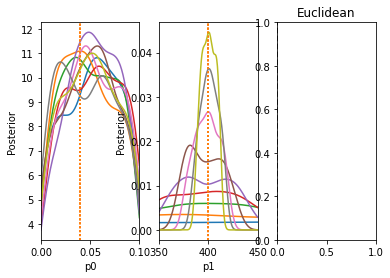

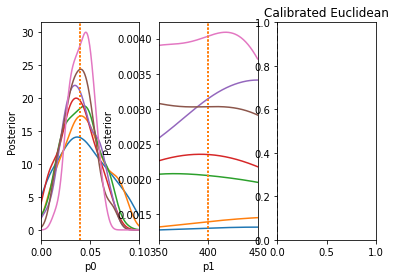

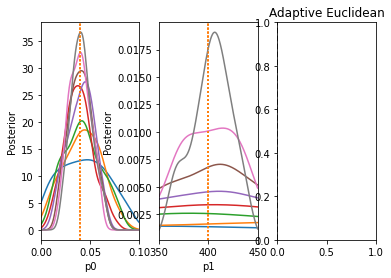

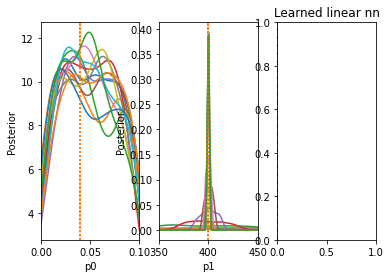

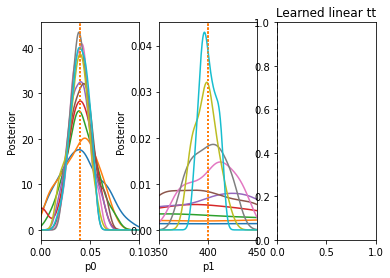

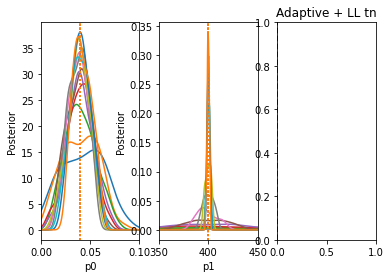

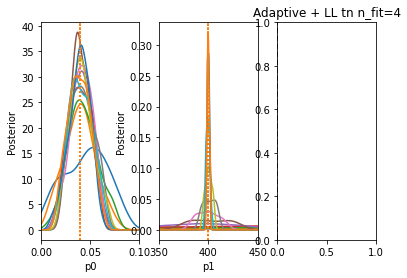

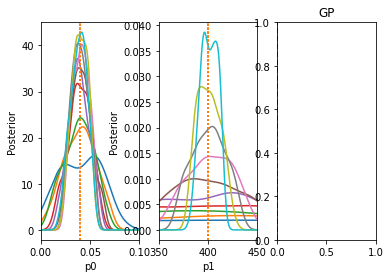

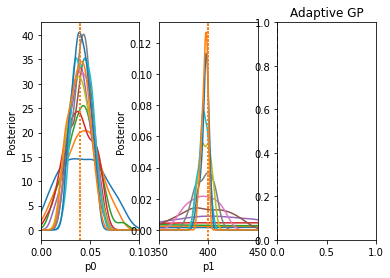

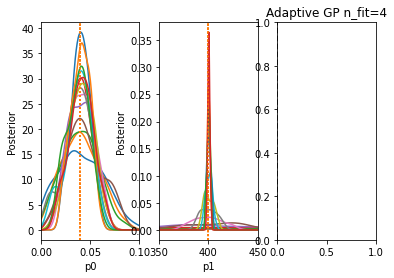

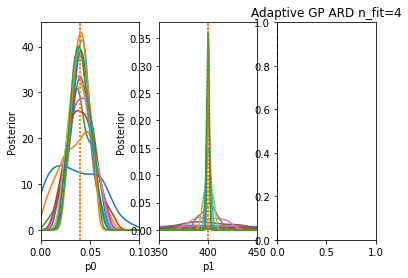

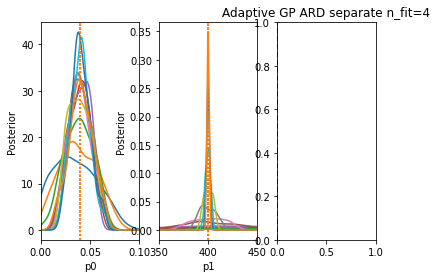

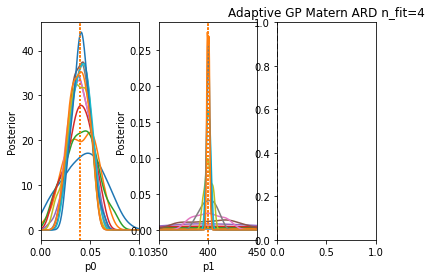

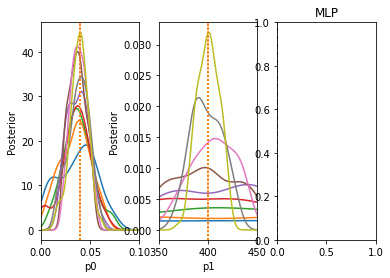

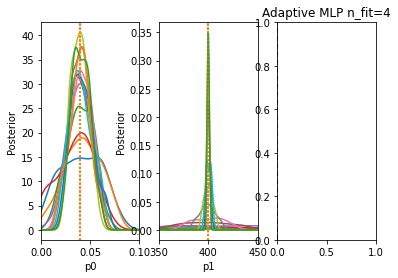

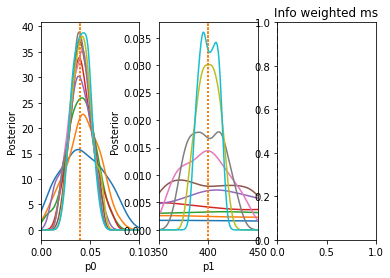

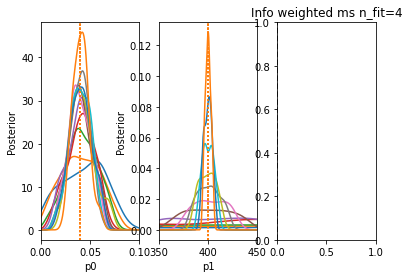

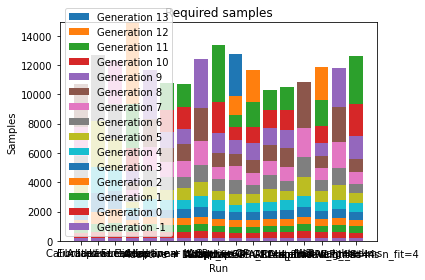

In [3]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

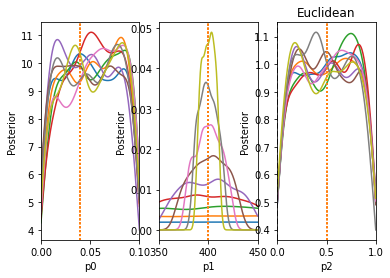

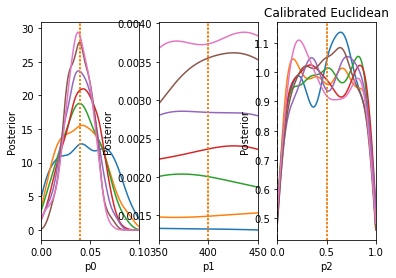

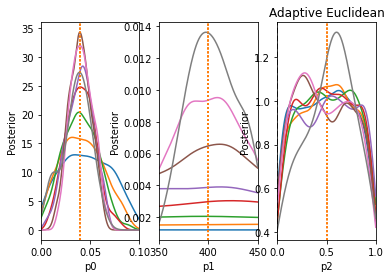

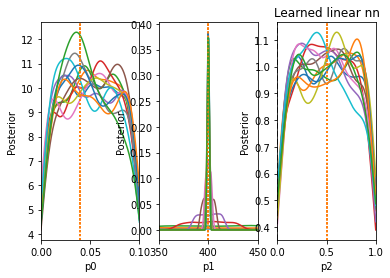

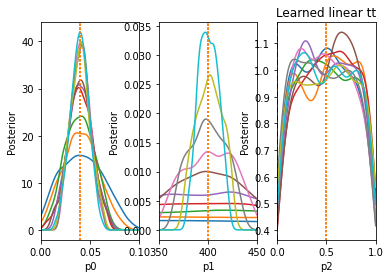

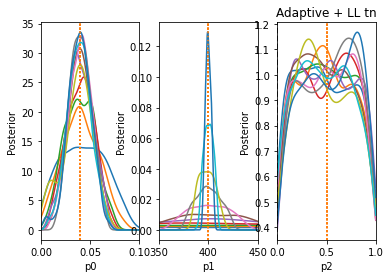

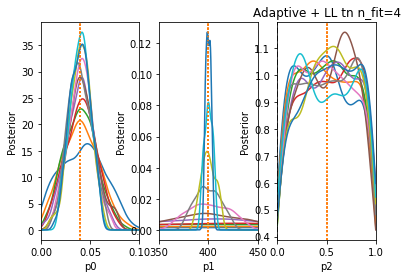

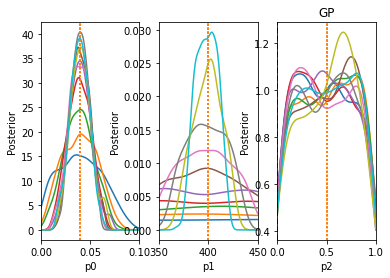

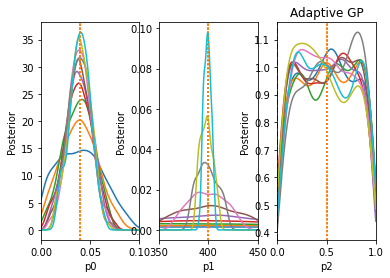

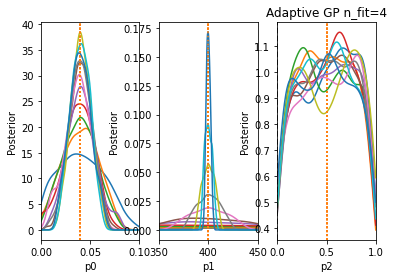

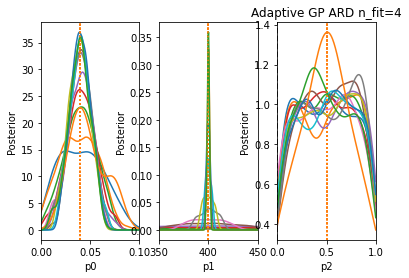

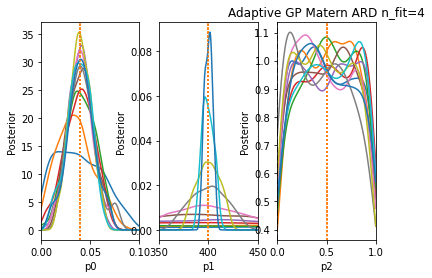

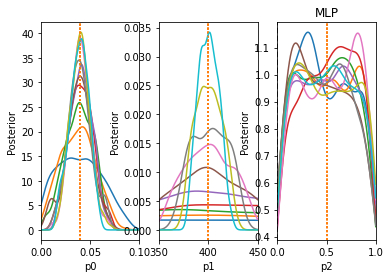

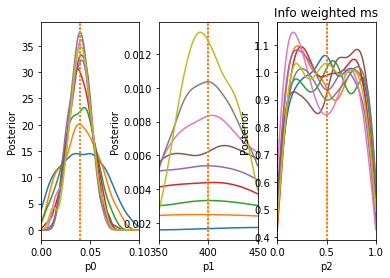

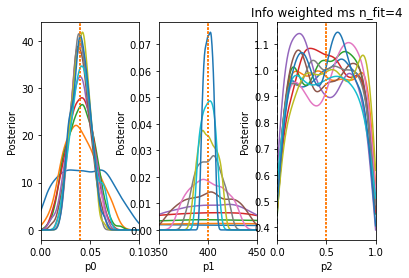

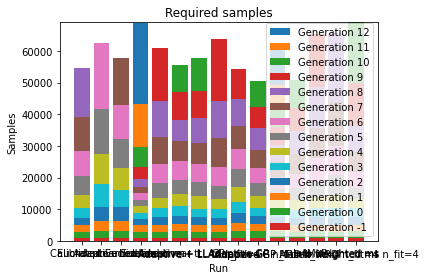

In [13]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)

<AxesSubplot:title={'center':'Required samples'}, xlabel='Run', ylabel='Samples'>

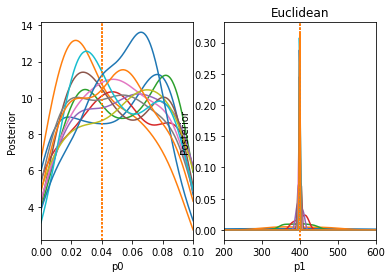

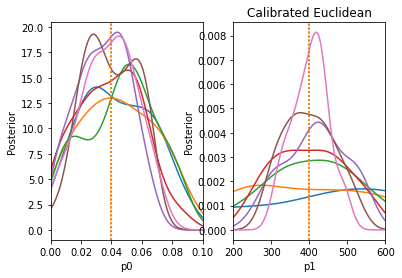

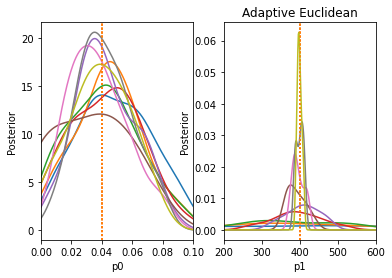

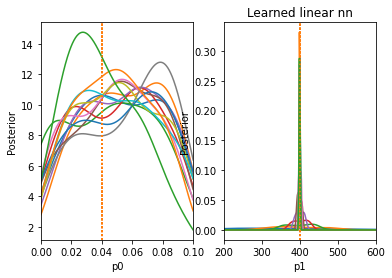

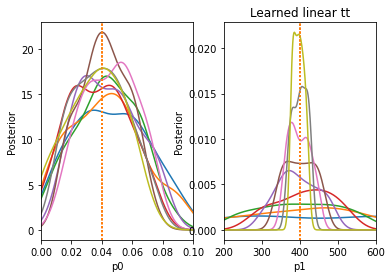

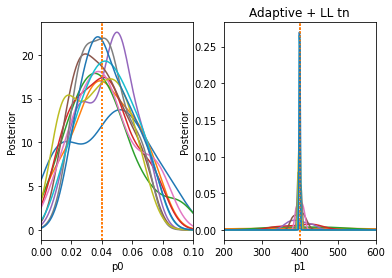

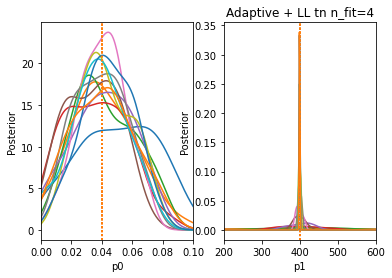

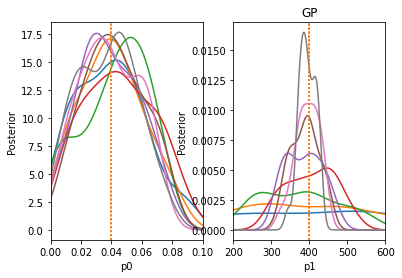

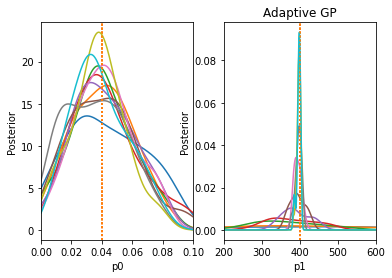

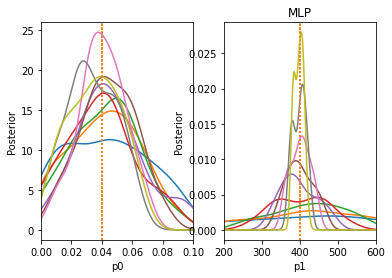

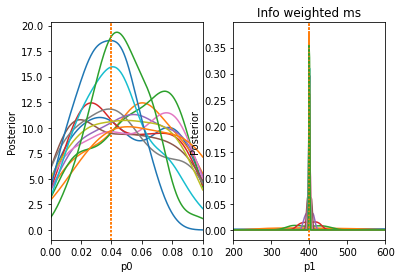

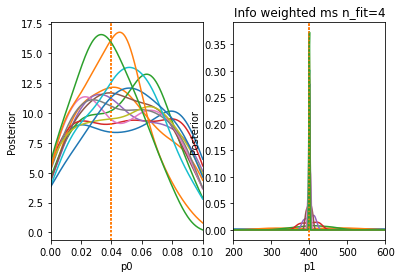

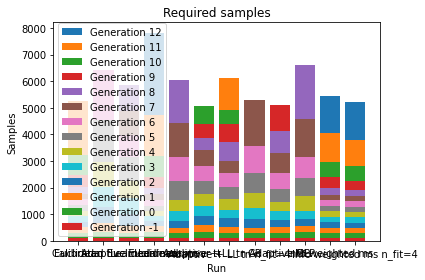

In [7]:
import matplotlib.pyplot as plt

for h, label in zip(hs, labels):
    plot_history(h, label)
pyabc.visualization.plot_sample_numbers(hs, labels)